<a href="https://colab.research.google.com/github/fralfaro/MAT281_2022/blob/main/homeworks/h2/hw_02.ipynb
" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tarea N°02

## Instrucciones

1.- Completa tus datos personales (nombre y rol USM) en siguiente celda.


* __Nombre__: Jean Luca Nanjari Pacheco

* __Rol__: 201810521-k

2.- Debes _subir_ este archivo con tus cambios a tu repositorio personal del curso, incluyendo datos, imágenes, scripts, etc.

3.- Se evaluará:
   - Soluciones
   - Código
   - Al presionar  `Kernel -> Restart Kernel and Run All Cells` deben ejecutarse todas las celdas sin error.

## I.- Clasificación de dígitos


En este laboratorio realizaremos el trabajo de reconocer un dígito a partir de una imagen.


![rgb](https://www.wolfram.com/language/11/neural-networks/assets.en/digit-classification/smallthumb_1.png)

El objetivo es a partir de los datos, hacer la mejor predicción de cada imagen. Para ellos es necesario realizar los pasos clásicos de un proyecto de _Machine Learning_, como estadística descriptiva, visualización y preprocesamiento. 

* Se solicita ajustar al menos tres modelos de clasificación:
 * Regresión logística
 * K-Nearest Neighbours 
 * Uno o más algoritmos a su elección [link](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) (es obligación escoger un _estimator_ que tenga por lo menos un hiperparámetro). 
 
 
* En los modelos que posean hiperparámetros es mandatorio buscar el/los mejores con alguna técnica disponible en `scikit-learn` ([ver más](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator)).
* Para cada modelo, se debe realizar _Cross Validation_ con 10 _folds_ utilizando los datos de entrenamiento con tal de determinar un intervalo de confianza para el _score_ del modelo.
* Realizar una predicción con cada uno de los tres modelos con los datos _test_ y obtener el _score_. 
* Analizar sus métricas de error (**accuracy**, **precision**, **recall**, **f-score**)



### Exploración de los datos
A continuación se carga el conjunto de datos a utilizar, a través del sub-módulo `datasets` de `sklearn`.

In [102]:
import os
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

%matplotlib inline

In [103]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/fralfaro/MAT281_2022/main/docs/lectures/data_manipulation/visualization/data/anscombe.csv"
)

df

,x1,y1,x2,y2,x3,y3,x4,y4
0,10,8.04,10,9.14,10,7.46,8,6.58
1,8,6.95,8,8.14,8,6.77,8,5.76
2,13,7.58,13,8.74,13,12.74,8,7.71
3,9,8.81,9,8.77,9,7.11,8,8.84
4,11,8.33,11,9.26,11,7.81,8,8.47
5,14,9.96,14,8.10,14,8.84,8,7.04
6,6,7.24,6,6.13,6,6.08,8,5.25
7,4,4.26,4,3.10,4,5.39,19,12.50
8,12,10.84,12,9.13,12,8.15,8,5.56
9,7,4.82,7,7.26,7,6.42,8,7.91


In [104]:
digits_dict = datasets.load_digits()
print(digits_dict["DESCR"])

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [105]:
digits_dict.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [106]:
digits_dict["target"]

array([0, 1, 2, ..., 8, 9, 8])

A continuación se crea dataframe declarado como `digits` con los datos de `digits_dict` tal que tenga 65 columnas, las 6 primeras a la representación de la imagen en escala de grises (0-blanco, 255-negro) y la última correspondiente al dígito (`target`) con el nombre _target_.

In [107]:
digits = (
    pd.DataFrame(
        digits_dict["data"],
    )
    .rename(columns=lambda x: f"c{x:02d}")
    .assign(target=digits_dict["target"])
    .astype(int)
)

digits.head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


### Ejercicio 1
**Análisis exploratorio:** Realiza tu análisis exploratorio, no debes olvidar nada! Recuerda, cada análisis debe responder una pregunta.

Algunas sugerencias:

* ¿Cómo se distribuyen los datos?
 - Se aplico una función para describir los datos en la primera casilla
* ¿Cuánta memoria estoy utilizando?
 - Al final, se pondrá una función que incluya todo el EDA
* ¿Qué tipo de datos son?
* ¿Cuántos registros por clase hay?
* ¿Hay registros que no se correspondan con tu conocimiento previo de los datos?

In [108]:
digits.describe()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c55,c56,c57,c58,c59,c60,c61,c62,c63,target
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


In [109]:
digits.dtypes.unique()

array([dtype('int64')], dtype=object)

In [110]:
# Empezamos con estadística descriptiva para ver como se distribuyen los datos

frames = []

for col in digits.columns:
  pd_series = digits[col]
    
    # elementos distintos 
  l_unique = pd_series.unique()
    
    # elementos vacios
  l_vacios = pd_series[pd_series.isna()]
    
  df_aux = pd.DataFrame({
        'columna': [col],
        'unicos': [len(l_unique)],
        'vacios': [len(l_vacios)]
    })
  frames.append(df_aux)
    
df_info = pd.concat(frames).reset_index(drop=True)
df_info['% vacios'] = df_info['vacios']/len(digits)
df_info

,columna,unicos,vacios,% vacios
0,c00,1,0,0.0
1,c01,9,0,0.0
2,c02,17,0,0.0
3,c03,17,0,0.0
4,c04,17,0,0.0
...,...,...,...,...
60,c60,17,0,0.0
61,c61,17,0,0.0
62,c62,17,0,0.0
63,c63,17,0,0.0


In [111]:
# efectuamos una limpieza de los datos
for col in digits.columns:
  digits[col].fillna(digits[col].mean(), inplace=True)

### Ejercicio 2
**Visualización:** Para visualizar los datos utilizaremos el método `imshow` de `matplotlib`. Resulta necesario convertir el arreglo desde las dimensiones (1,64)  a (8,8) para que la imagen sea cuadrada y pueda distinguirse el dígito. Superpondremos además el label correspondiente al dígito, mediante el método `text`. Esto nos permitirá comparar la imagen generada con la etiqueta asociada a los valores. Realizaremos lo anterior para los primeros 25 datos del archivo.

In [112]:
digits_dict["images"][0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Visualiza imágenes de los dígitos utilizando la llave `images` de `digits_dict`. 

> **Sugerencia**: Utiliza `plt.subplots` y el método `imshow`. Puedes hacer una grilla de varias imágenes al mismo tiempo!

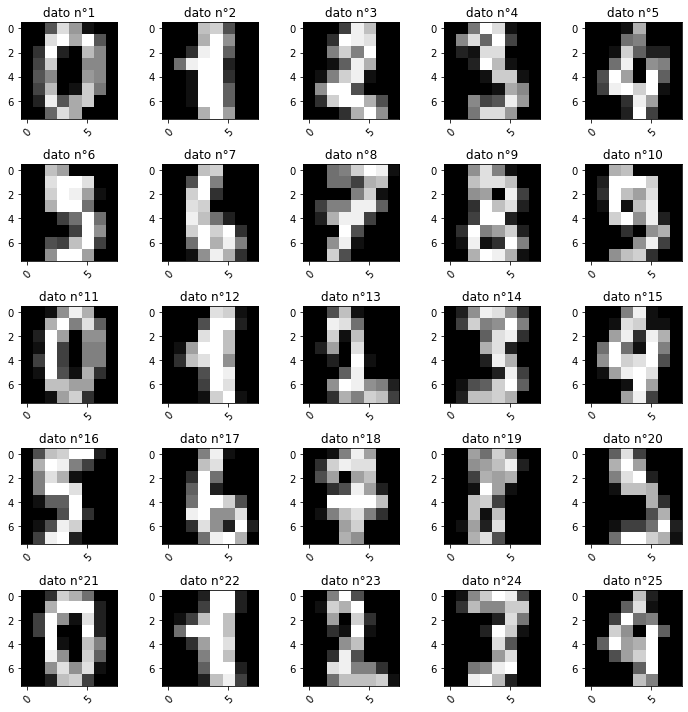

In [113]:
nx, ny = 5,5
fig, axs = plt.subplots(nx, ny, figsize=(10, 10))
c = 0
for i in range(0, nx):
  for j in range(0,ny):
    im = axs[i][j].imshow(digits_dict["images"][c], cmap='gray')
    # Se gira las etiquetas de marca para mejor visualización y se establece su alineación.
    plt.setp(axs[i][j].get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Se recorren las dimensiones de los datos y se crean anotaciones de texto.
    axs[i][j].set_title("dato n°"+str(c+1))
    fig.tight_layout()
    c = c+1
plt.show()

### Ejercicio 3

**Machine Learning**: En esta parte usted debe entrenar los distintos modelos escogidos desde la librería de `skelearn`. Para cada modelo, debe realizar los siguientes pasos:

* **train-test** 
 * Crear conjunto de entrenamiento y testeo (usted determine las proporciones adecuadas).
 * Imprimir por pantalla el largo del conjunto de entrenamiento y de testeo.
 
 
* **modelo**:
 * Instanciar el modelo objetivo desde la librería sklearn.
 * *Hiper-parámetros*: Utiliza `sklearn.model_selection.GridSearchCV` para obtener la mejor estimación de los parámetros del modelo objetivo.




* **Métricas**:
 * Graficar matriz de confusión.
 * Analizar métricas de error.



__Preguntas a responder:__

* ¿Cuál modelo es mejor basado en sus métricas?
* ¿Cuál modelo demora menos tiempo en ajustarse?
* ¿Qué modelo escoges?


In [114]:
# Antes de todo, importamos todos los módulos que usaremos
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV # Grid Seach con validación cruzada
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# adoptamos los datos que dieron
X = pd.DataFrame(digits.drop(columns="target"))
y = pd.DataFrame(digits["target"])

# y también se definen las métricas de error que serán usadas
def summary_metrics(y_true, y_pred) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    df_result['accuracy'] = [round(accuracy_score(y_true,y_pred),4)]
    df_result['recall'] = [round(recall_score(y_true,y_pred, average="macro"),4)]
    df_result['precision'] = [round(precision_score(y_true,y_pred, average="macro"),4)]
    df_result['fscore'] = [round(f1_score(y_true,y_pred, average="macro"),4)]


    return df_result

1) REGRESIÓN LOGÍSTICA

In [115]:
# conjunto de datos dividido
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 2)

# vemos los datos de testeo y entrenamiento
print('Separando informacion:\n')
print('numero de filas data original : ',len(X))
print('numero de filas train set     : ',len(X_train))
print('numero de filas test set      : ',len(X_test))

Separando informacion:

numero de filas data original :  1797
numero de filas train set     :  1437
numero de filas test set      :  360


In [116]:
# Creamos y ajustamos el modelo
rlog = LogisticRegression()
rlog.fit(X_train, Y_train)
rlog.score(X_train,Y_train)
rlog.predict_log_proba(X_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[-2.68082098e+01, -2.09054261e+01, -3.02979304e+01, ...,
        -2.54156397e+01, -1.22286393e+01, -7.96472455e-03],
       [-3.66977607e+01, -2.70884885e+01, -1.43958635e-07, ...,
        -1.98472993e+01, -1.85460782e+01, -3.03874039e+01],
       [-2.35579474e+01, -1.34390218e+01, -4.53665090e-06, ...,
        -3.30599608e+01, -1.50071330e+01, -1.97865143e+01],
       ...,
       [-2.67599417e+01, -2.82746420e-05, -3.44381150e+01, ...,
        -2.42239171e+01, -1.11288752e+01, -1.13205059e+01],
       [-2.31871476e+01, -8.80163943e-03, -4.74629063e+00, ...,
        -3.47472302e+01, -1.04163970e+01, -1.29077076e+01],
       [-3.51664894e+01, -2.04999950e+01, -2.46192429e+01, ...,
        -1.84285471e+01, -2.40482444e+01, -2.20560906e+01]])

In [117]:
# rango de parametros
rango_solver=['newton-cg', 'lbfgs', 'liblinear']
rango_max_iter =np.array( [4,5,6,7,8,9,10])
param_grid = dict(solver=rango_solver, max_iter=rango_max_iter)

# aplicar greed search con validación cruzada
gs = GridSearchCV(estimator=rlog, 
                  param_grid=param_grid, 
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1
                  )

gs = gs.fit(X_train, Y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [118]:
# imprimir resultados
print(gs.best_score_)
print(gs.best_params_)

0.9728486790986791
{'max_iter': 8, 'solver': 'newton-cg'}


In [119]:
# utilizando el mejor modelo
mejor_modelo = gs.best_estimator_
mejor_modelo.fit(X_train, Y_train)
print('Precisión: {0:.3f}'.format(mejor_modelo.score(X_test, Y_test))+"\n")

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precisión: 0.953



/usr/local/lib/python3.8/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


In [120]:
# ahora, veamos la matrix de confusión

y_true = (Y_test["target"].values)
y_pred = (rlog.predict(X_test)) # se crean los datos de la predicción del modelo 

print('\nMatriz de confusion:\n ')
print(confusion_matrix(y_true,y_pred))


Matriz de confusion:
 
[[31  0  0  0  1  0  0  0  0  0]
 [ 0 41  0  1  0  0  0  0  1  1]
 [ 0  0 31  0  0  0  0  0  0  0]
 [ 0  0  0 33  0  0  0  1  2  0]
 [ 0  0  0  0 31  0  0  0  3  1]
 [ 0  1  0  0  1 41  0  0  0  0]
 [ 0  1  0  0  0  0 33  0  1  0]
 [ 0  0  0  0  0  0  0 39  0  1]
 [ 0  0  0  0  0  0  0  0 35  1]
 [ 0  0  0  1  0  1  0  0  1 25]]


In [121]:
# Por último, visualizamos los valores que nos entregan las métricas de error
summary_metrics(y_true, y_pred)

,accuracy,recall,precision,fscore
0,0.9444,0.9439,0.9463,0.9442


2) VECINOS MÁS CERCANOS

In [122]:
# conjunto de datos dividido
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

# vemos los datos de testeo y entrenamiento
print('Separando informacion:\n')
print('numero de filas data original : ',len(X))
print('numero de filas train set     : ',len(X_train))
print('numero de filas test set      : ',len(X_test))

Separando informacion:

numero de filas data original :  1797
numero de filas train set     :  1347
numero de filas test set      :  450


In [123]:
# le aplicamos una normalización a los datos
sc = StandardScaler()

# se crea y ajusta el modelo
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
classifier = KNeighborsClassifier(n_neighbors = 5, metric = "minkowski", p=2)
classifier.fit(X_train, Y_train)
y_pred = classifier.predict(X_test)
y_true = (Y_test["target"].values)

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [124]:
# rango de parametros
rango_algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
rango_n_neighbors =np.array( [4,5,6,7,8])
param_grid = dict(algorithm=rango_algorithm, n_neighbors=rango_n_neighbors)

# aplicar greed search con validación cruzada
knn_gs = GridSearchCV(estimator=classifier, 
                  param_grid=param_grid, 
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)

knn_gs = knn_gs.fit(X_train, Y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [125]:
# imprimir resultados
print(knn_gs.best_score_)
print(knn_gs.best_params_)

0.9740187949143172
{'algorithm': 'auto', 'n_neighbors': 5}


In [126]:
# utilizando el mejor modelo
mejor_modelo = knn_gs.best_estimator_
mejor_modelo.fit(X_train, Y_train)
print('Precisión: {0:.3f}'.format(mejor_modelo.score(X_test, Y_test))+"\n")

Precisión: 0.973



/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [127]:
# ahora, veamos la matrix de confusión

print('\nMatriz de confusion:\n ')
print(confusion_matrix(y_true,y_pred))


Matriz de confusion:
 
[[37  0  0  0  0  0  0  0  0  0]
 [ 0 43  0  0  0  0  0  0  0  0]
 [ 0  1 42  1  0  0  0  0  0  0]
 [ 0  0  0 44  0  0  0  0  1  0]
 [ 0  0  0  0 36  0  0  2  0  0]
 [ 0  0  0  0  0 47  0  0  0  1]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  0  0  0  1  0  0 47  0  0]
 [ 0  1  0  2  0  0  0  0 45  0]
 [ 0  0  0  0  0  1  0  1  0 45]]


In [128]:
# Por último, visualizamos los valores que nos entregan las métricas de error
summary_metrics(y_true, y_pred)

,accuracy,recall,precision,fscore
0,0.9733,0.9733,0.974,0.9734


3) RANDOM FOREST CLASSIFIER

In [129]:
# conjunto de datos dividido
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

# vemos los datos de testeo y entrenamiento
print('Separando informacion:\n')
print('numero de filas data original : ',len(X))
print('numero de filas train set     : ',len(X_train))
print('numero de filas test set      : ',len(X_test))

Separando informacion:

numero de filas data original :  1797
numero de filas train set     :  1437
numero de filas test set      :  360


In [130]:
# Normalizamos los datos y creamos el modelo
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

bosque = RandomForestClassifier()
bosque.fit(X_train_std, Y_train)
y_pred = bosque.predict(X_test) # se crean los datos de la predicción del modelo 
y_true = (Y_test["target"].values)

<ipython-input-130-dbb3c600c4b0>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  bosque.fit(X_train_std, Y_train)
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [131]:
# rango de parametros
rango_criterion = ["gini", "entropy"]
rango_max_depth =np.array( [4,5,6,7,8])
param_grid = dict(criterion=rango_criterion, max_depth=rango_max_depth)

# aplicar greed search con validación cruzada
gs = GridSearchCV(estimator=bosque, 
                  param_grid=param_grid, 
                  scoring='accuracy',
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, Y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [132]:
# imprimir resultados
print(gs.best_score_)
print(gs.best_params_)

0.9721590909090908
{'criterion': 'entropy', 'max_depth': 8}


In [133]:
# utilizando el mejor modelo
mejor_modelo = gs.best_estimator_
mejor_modelo.fit(X_train, Y_train)
print('Precisión: {0:.3f}'.format(mejor_modelo.score(X_test, Y_test))+"\n")

<ipython-input-133-45b546c73361>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  mejor_modelo.fit(X_train, Y_train)


Precisión: 0.981



In [134]:
# ahora, veamos la matrix de confusión

print('\nMatriz de confusion:\n ')
print(confusion_matrix(y_true,y_pred))


Matriz de confusion:
 
[[32  6  0  0  0  0  0  0  5  0]
 [ 0 34  0  0  0  0  0  0  1  0]
 [ 0 11  0  0  0  0  0  0 25  0]
 [ 1  7  0  0  0  0  0  0 31  2]
 [ 1 26  0  0 10  0  1  0  0  0]
 [ 1 13  0  0  0  0  0  0 15  1]
 [ 0 26  0  0  0  0 11  0  0  0]
 [ 0 20  0  0  0  0  0  0 17  0]
 [ 0 17  0  0  0  0  0  0 12  0]
 [ 0  5  0  0  0  0  0  0 15 14]]


In [135]:
# Por último, visualizamos los valores que nos entregan las métricas de error
summary_metrics(y_true, y_pred)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,recall,precision,fscore
0,0.3139,0.3102,0.396,0.2735


Se decide en base a los resultados entregados por las métricas que el mejor modelo es el de los vecinos cercanos. 

### Ejercicio 4

__Comprensión del modelo:__ Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, debe comprender e interpretar minuciosamente los resultados y gráficos asocados al modelo en estudio, para ello debe resolver los siguientes puntos:



 * **Cross validation**: usando **cv** (con n_fold = 10), sacar una especie de "intervalo de confianza" sobre alguna de las métricas estudiadas en clases: 
  * $\mu \pm \sigma$ = promedio $\pm$ desviación estandar
 * **Curva de Validación**: Replica el ejemplo del siguiente [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html#sphx-glr-auto-examples-model-selection-plot-validation-curve-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.
 * **Curva AUC–ROC**: Replica el ejemplo del siguiente  [link](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py) pero con el modelo, parámetros y métrica adecuada. Saque conclusiones del gráfico.

In [136]:
# Se halla un promedio y una precisión para el intervalo de confianza
prec = [round(x,2) for x in cross_val_score(estimator=knn_gs, X=X_train, y=Y_train, cv=10)]
print("")
print("Precisión (+/-): ", np.std(prec))
print("Promedio: ", np.mean(prec))

/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam


Precisión (+/-):  0.010198039027185577
Promedio:  0.984


/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

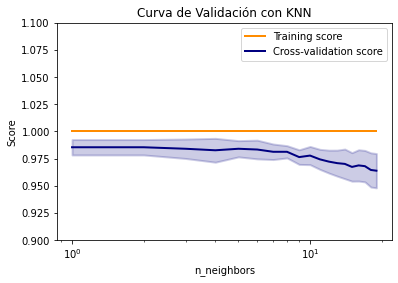

In [137]:
from sklearn.model_selection import validation_curve


# Escogemos nuestros hiperparámetros

param_range = np.arange(1,20,1) 

train_scores, test_scores = validation_curve(
    KNeighborsClassifier(weights = 'distance',metric = 'euclidean'), X_train, Y_train, param_name="n_neighbors", param_range=param_range,
    scoring="accuracy", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Curva de Validación con KNN")
plt.xlabel("n_neighbors")
plt.ylabel("Score")
plt.ylim(0.9, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",color="darkorange", lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,color="darkorange", lw=lw)

plt.semilogx(param_range, test_scores_mean, 
             label="Cross-validation score",color="navy", lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,color="navy", lw=lw)

plt.legend(loc="best")

plt.show()


El modelo de los vecinos cercanos se ajusta bien en general o al menos para el dataset de este caso. Se puede apreciar como el la curva de cross validation score va en descenso en la medida que aumenta los vecinos a partir de cierta cantidad de estos. Cabe mencionar que este gráfico sirve para indicarnos si tenemos overfitting.

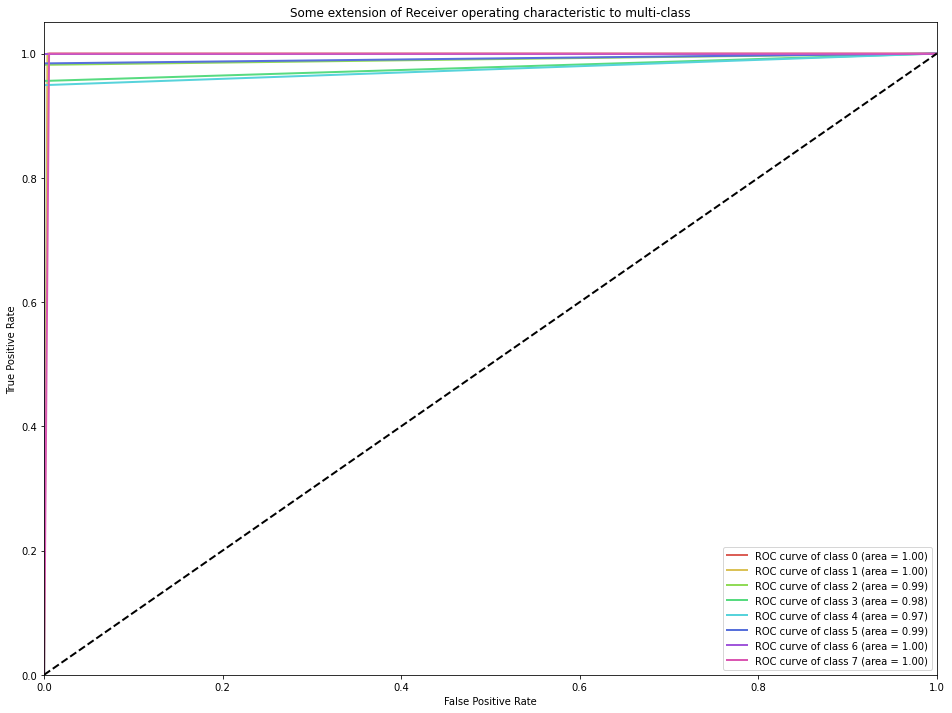

In [138]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from numpy import interp
from sklearn.metrics import roc_auc_score

y = label_binarize(y, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = y.shape[1]

n_samples, n_features = X.shape

X_train, X_test, Y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)

classifier = KNeighborsClassifier(algorithm='auto', metric='euclidean', n_neighbors=3, weights='distance')
y_score = classifier.fit(X_train, Y_train).predict(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

import sys
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.rcParams["figure.figsize"] = (16,12)
colors = sns.color_palette("hls", 8)
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

Se puede ver que el modelo funciona bien en términos de predicción, por lo juntas que se ven las curvas.

### Ejercicio 5
__Reducción de la dimensión:__ Tomando en cuenta el mejor modelo encontrado en el `Ejercicio 3`, debe realizar una redcción de dimensionalidad del conjunto de datos. Para ello debe abordar el problema ocupando los dos criterios visto en clases:  

* **Selección de atributos**
* **Extracción de atributos**

__Preguntas a responder:__

Una vez realizado la reducción de dimensionalidad, debe sacar algunas estadísticas y gráficas comparativas entre el conjunto de datos original y el nuevo conjunto de datos (tamaño del dataset, tiempo de ejecución del modelo, etc.)


In [139]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


X = pd.DataFrame(digits.drop(["target"], axis=1)) 
y = digits["target"]

k = 15  # número de atributos a seleccionar
columns = list(X.columns.values)
seleccionados = SelectKBest(f_classif, k=k).fit(X, y)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 32 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [140]:
soporte = seleccionados.get_support()
atributos = [columns[i] for i in list(soporte.nonzero()[0])]
atributos

['c10',
 'c13',
 'c20',
 'c21',
 'c26',
 'c28',
 'c30',
 'c33',
 'c34',
 'c36',
 'c42',
 'c43',
 'c46',
 'c60',
 'c61']

In [141]:
# Ahora, ponemos en marcha el modelo utilizando PCA
from sklearn.decomposition import PCA

X = StandardScaler().fit_transform(X)
pca = PCA(n_components=15)
componentes_principales = pca.fit_transform(X)
seleccionados = SelectKBest(f_classif, k=k).fit(X, y)


/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 0 32 39] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


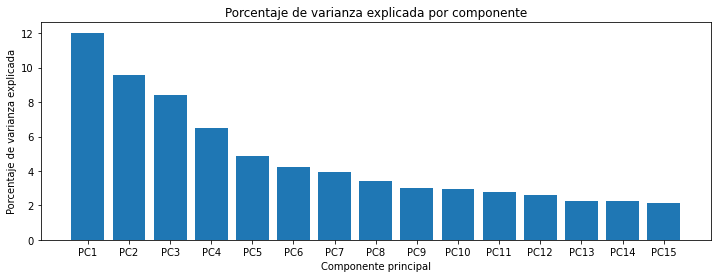

In [142]:
# graficar varianza por cada componente (esté y el gráficos que le sigue se vieron en la materia de clases)
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columnas=[]
for i in range(1, 16):
    columnas.append("PC"+str(i))

plt.figure(figsize=(12,4))
plt.bar(x= range(1,16), height=percent_variance, tick_label=columnas)
plt.ylabel('Porcentaje de varianza explicada')
plt.xlabel('Componente principal')
plt.title('Porcentaje de varianza explicada por componente')
plt.show()

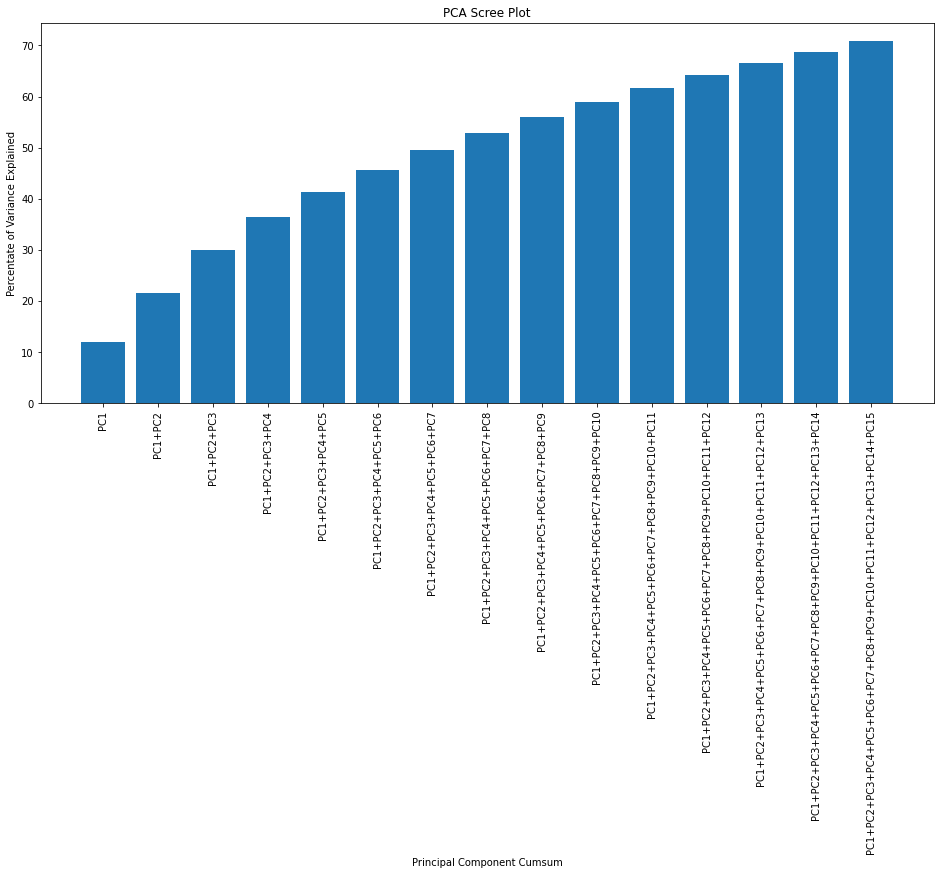

In [143]:
# graficar varianza por la suma acumulada de los componentes
percent_variance_cum = np.cumsum(percent_variance)
columnas = []
for i in range(1,16):
  aux = ""
  for j in range(0,i):
    if i == 0 or j == 0:
      aux = aux + "PC" + str(j+1)
    else:
      aux = aux + "+PC" + str(j+1)
  columnas.append(aux)
    
columnas

plt.figure(figsize=(16,7))
plt.bar(x= range(1,16), height=percent_variance_cum, tick_label=columnas)
plt.ylabel('Percentate of Variance Explained')
plt.xticks(x= range(1,16), rotation='vertical')
plt.xlabel('Principal Component Cumsum')
plt.title('PCA Scree Plot')
plt.show()

In [144]:
Xk = pd.DataFrame(X,columns=columns)[atributos]
X_train2, X_test2, y_train2, y_test2 = train_test_split(Xk, y, test_size=0.33, random_state=2)

prec = cross_val_score(estimator=knn_gs,X=X_train2,y=y_train2,cv=10)

precision = [round(x,2) for x in prec]

print("Promedio", np.mean(precision))
print("Precisión(+/-)", np.std(precision))


Promedio 0.9530000000000001
Precisión(+/-) 0.021470910553583883


In [145]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(componentes_principales, y, test_size=0.33, random_state=2)

classifier = KNeighborsClassifier(weights = 'distance',metric = 'euclidean', n_neighbors = 3)

prec = cross_val_score(estimator=knn_gs,X=X_train3,y=y_train3,cv=10)

precision = [round(x,2) for x in prec]

print("Promedio: ", np.mean(precision))
print("Precisión(+/-): ", np.std(precision))


Promedio:  0.969
Precisión(+/-):  0.013747727084867531


In [146]:
import time

# Seleccionamos los hiperparámetros

parametros = { 'weights' : ['distance','uniform'], 'n_neighbors' : [5, 10, 15, 20], 'metric' : ['manhattan', 'euclidean'],
}
model_knn = KNeighborsClassifier()
knn_gs = GridSearchCV(estimator = model_knn, param_grid = parametros, cv = 10)

start_time = time.time()

result1 = knn_gs.fit(X_train2, y_train2)

print('KNN with GridSearch and atributes')
print("--- %s segundos ---" % (time.time() - start_time))

# Extracción de atributos

start_time = time.time()

result2 = knn_gs.fit(X_train3, y_train3)

print('')
print('KNN with PCA')
print("--- %s segundos ---" % (time.time() - start_time))


KNN with GridSearch and atributes
--- 2.1059277057647705 segundos ---

KNN with PCA
--- 2.350752592086792 segundos ---


Básicamente se gano velocidad a cambio de menos precisión, sin embargo, vemos que est último no se redujo tanto en comparación a la velocidad, lo cual es un buen indicio 

### Ejercicio 6


__Visualizando Resultados:__ A continuación se provee código para comparar las etiquetas predichas vs las etiquetas reales del conjunto de _test_. 


In [154]:
def mostar_resultados(digits,model,nx=5, ny=5,label = "correctos"):
    """
    Muestra los resultados de las prediciones de un modelo 
    de clasificacion en particular. Se toman aleatoriamente los valores
    de los resultados.
    
    - label == 'correcto': retorna los valores en que el modelo acierta.
    - label == 'incorrecto': retorna los valores en que el modelo no acierta.

    
    Observacion: El modelo que recibe como argumento debe NO encontrarse
    'entrenado'.
    
    
    :param digits: dataset 'digits'
    :param model: modelo de sklearn
    :param nx: numero de filas (subplots)
    :param ny: numero de columnas (subplots)
    :param label: datos correctos o incorrectos
    :return: graficos matplotlib
    """
    
    
    X = digits.drop(columns="target").values
    y = digits["target"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state = 42) 
    model.fit(X_train, Y_train) # ajustando el modelo
    y_pred = list(model.predict(X_test))

    
    # Mostrar los datos correctos
    if label=="correctos":
        mask = (y_pred == Y_test)
        color = "green"
        
    # Mostrar los datos correctos
    elif label=="incorrectos":
        mask = (y_pred != Y_test)
        color = "red"
    
    else:
        raise ValueError("Valor incorrecto")
        
    X_aux = X_test[mask]
    y_aux_true = Y_test[mask]
    y_aux_pred = np.array(y_pred)[mask]
    
    # We'll plot the first 100 examples, randomly choosen
    fig, ax = plt.subplots(nx, ny, figsize=(12,12))
    fix = X_aux.shape[0]
    for i in range(nx):
        for j in range(ny):
            index = j + ny * i
            if index < fix:
                data  = X_aux[index, :].reshape(8,8)
                label_pred = str(int(y_aux_pred[index]))
                label_true = str(int(y_aux_true[index]))
                ax[i][j].imshow(data, interpolation='nearest', cmap='gray_r')
                ax[i][j].text(0, 0, label_pred,
                              horizontalalignment='center',
                              verticalalignment='center',
                              fontsize=10,
                              color=color)
                ax[i][j].text(7, 0, label_true,
                              horizontalalignment='center',
                              verticalalignment='center',
                              fontsize=10,
                              color='blue')
                ax[i][j].get_xaxis().set_visible(False)
                ax[i][j].get_yaxis().set_visible(False)
    plt.show()

**Pregunta**

* Tomando en cuenta el mejor modelo entontrado en el `Ejercicio 3`, grafique los resultados cuando:
 * el valor predicho y original son iguales
 * el valor predicho y original son distintos 


* Cuando el valor predicho y original son distintos ,  ¿Por qué ocurren estas fallas?

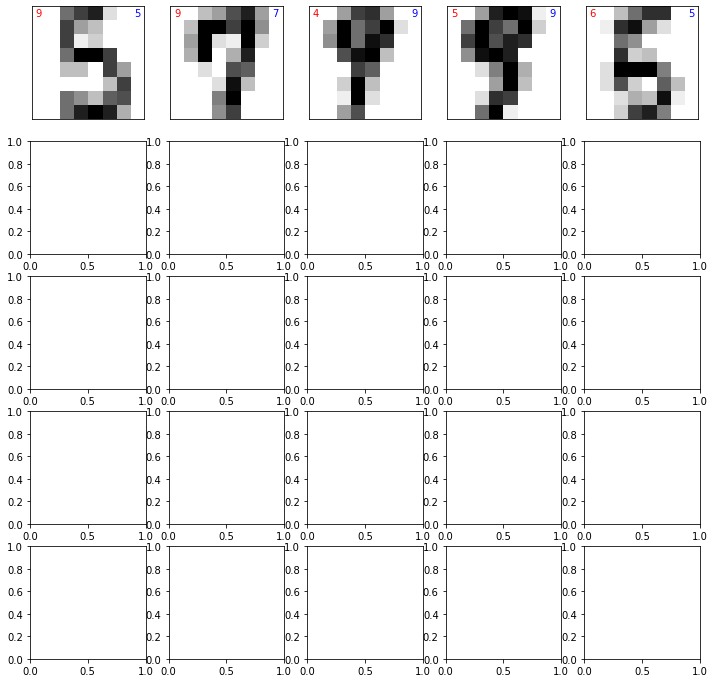

In [156]:
mostar_resultados(digits,KNeighborsClassifier(),nx=5, ny=5,label = "incorrectos")

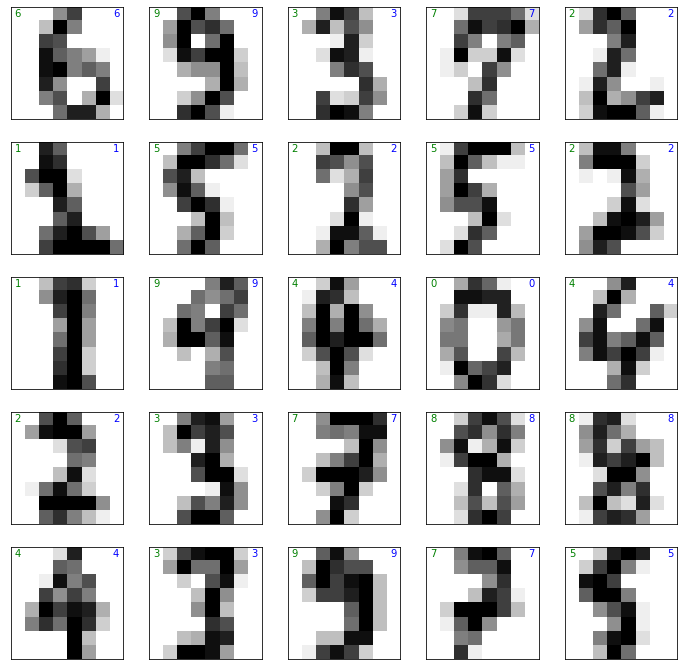

In [155]:
mostar_resultados(digits,KNeighborsClassifier(),nx=5, ny=5,label = "correctos")

Son fallas deben ser por la naturaleza del dataset, sin embargo en general el modelo funciona bien.

### Ejercicio 7
**Conclusiones**: Entrega tu veredicto, responde las preguntas iniciales, visualizaciones, trabajos futuros, dificultades, etc.

Antes que nada, quisiera mencionar que las métricas útiles para estar atentos al overfitting, igual me queda la duda de que podría haber pasado con otros modelos respecto a esto. Por otro lado, pese a que KNN tuvo que trabajar con menos vecinos en la reducción dimensional, creo que en general funciono bien, asegurando que el modelo se empleara eficientemente. A estas alturas, no sabría que más agregar, pues pienso que estuvo bien aplicado.

## II.- California Housing Prices


<img src="https://www.wartsila.com/images/default-source/default-album/california_housing.tmb-1920x690.jpg?sfvrsn=126bc44_1" width="480" height="240" align="center"/>

Los datos se refieren a las casas encontradas en un distrito determinado de California y algunas estadísticas resumidas sobre ellas basadas en los datos del censo de 1990. Tenga en cuenta que los datos no se limpian, por lo que se requieren algunos pasos de procesamiento previo.

Las columnas son las siguientes, sus nombres se explican por sí mismos:

* longitude
* latitude
* housingmedianage
* total_rooms
* total_bedrooms
* population
* households
* median_income
* medianhousevalue
* ocean_proximity


El objetivo es poder predecir el valor promedio de cada propiedad. 
Para poder completar correctamente este laboratorio, es necesario seguir la siguiente rúbrica de trabajo:

1. Definición del problema
2. Estadística descriptiva
3. Visualización descriptiva
4. Preprocesamiento
5. Selección de modelo 
    1. Por lo menos debe comparar cuatro modelos
    2. Al menos tres de estos modelos tienen que tener hiperparámetros.
    3. Realizar optimización de hiperparámetros.
6. Métricas y análisis de resultados
7. Visualizaciones del modelo
8. Conclusiones

> **Observación**: Puede tomar como referencia lo realizado en la sección **I.- Clasificación de dígitos**. El alumno tiene la libertad de desarrollar un análisis más completo del problema (si así lo desea). Puede tomar como referencia el siguiente [link](https://www.kaggle.com/camnugent/california-housing-prices).

In [149]:
# read data
housing = pd.read_csv('data/housing.csv',sep=',')
housing.head()

FileNotFoundError: ignored

In [ ]:
## FIX ME PLEASE